# APS1070
#### Anomaly Detection - Project 2



Project 2 has two parts: a tutorial component (which will be covered in labs) and an exercises component (to be completed as homework, individually). Overall, this project is worth 12.5% of your final grade. Completing the tutorial section is worth 2.5 marks. The exercises section will be graded out of the remaining 10 marks.


Please fill out the following:


*   Your **name**: **Karthik Mohan**
*   Your **student number**: **1006179145**



## Tutorial

In this part of the assignment, we will implement an anomaly detection algorithm using the Gaussian model to detect anomalous behavior in a 2D dataset first and then a high-dimensional dataset.

Loading relevant libraries and the dataset

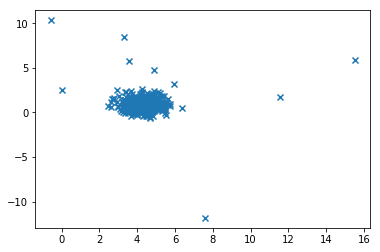

In [170]:
import numpy as np
import matplotlib.pyplot as plt


from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=1,
                       cluster_std=0.60, random_state=0)
# print(X, y_true)
X_append, y_true_append = make_blobs(n_samples=10,centers=1,cluster_std=5,random_state=0)
# print(X_append, y_true_append)
X = np.vstack([X,X_append])
y_true = np.hstack([y_true, [1 for _ in y_true_append]])
X = X[:, ::-1] # flip axes for better plotting
plt.scatter(X[:,0],X[:,1],marker="x");
# print(X)

Here we've manufactured a dataset where some points are visibly outliers from the main distribution.

We can see this from looking at the plot, but how do we robustly identify the outliers? 

That's where a Gaussian estimation comes in. For this dataset, we only need a single Gaussian, for which we are gonna calculate the mean and standard deviation. Then, we're able to find the points that don't seem likely to have originated from that distribution - these are our outliers!

First, we need to calculate the mean and variance for our data. Complete the function below to generate these values using these formulae:

$$\mu = \frac{1}{m} \sum_{i=1}^{m}X_i$$

$$\sigma^2 = \frac{1}{m} \sum_{i=1}^{m}(X_i-\mu)^2$$

In [171]:
def estimateGaussian(X):
    """
     This function provides an estimate of mean and variance 
     of a Gaussian distribution along multiple dimensions
     using X, an N-dimensional vector
    """
    
    m = X.shape[0]
    print(m)
    
    #compute mean of X
    sum_ = np.sum(X, axis = 0)
    print(sum_)
    mu = 1/m * sum_
    # compute variance of X
    var = 1/m * np.sum((X - mu)**2, axis = 0)
    
    return mu,var
mu, sigma = estimateGaussian(X)

410
[1766.16061576  400.00301051]


In [172]:
print((X.shape))
print(type(mu))
print(mu.shape)
print(mu)
print(sigma)

(410, 2)
<class 'numpy.ndarray'>
(2,)
[4.30770882 0.9756171 ]
[0.94147734 1.25990509]


Now, we will calculate for each point in X, the probability of the distribution $N(\mu,\sigma^2)$ generating that point randomly. This has been completed for you, although it is important to understand how the calculation of the PDF works.

In [0]:
def multivariateGaussian(X, mu, sigma):
    """
    This function computes the probability density function of a multivariate gaussian distribution.
    """
    k = len(mu)
    
    sigma=np.diag(sigma)
    X = X - mu.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(sigma)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(sigma) * X,axis=1))
    return p
p = multivariateGaussian(X, mu, sigma)
# print(p)

Now that we have the probability of each point in the dataset, we can plot these on the original scatterplot:

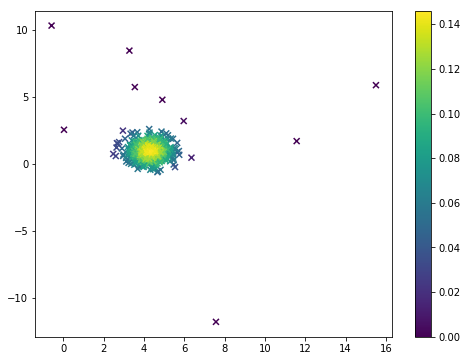

In [174]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0],X[:,1],marker="x",c=p,cmap='viridis');
plt.colorbar();

We're getting closer to the point where we can programatically identify our outliers for a single Gaussian distribution. The last step is to identify a value for $p$, below which we consider a point to be an outlier. We term this $\epsilon$.

In [0]:
#Choose a value for epsilon

epsilon = 0.0259


Now we'll highlight on the scatter plot all points that are below $\epsilon$:

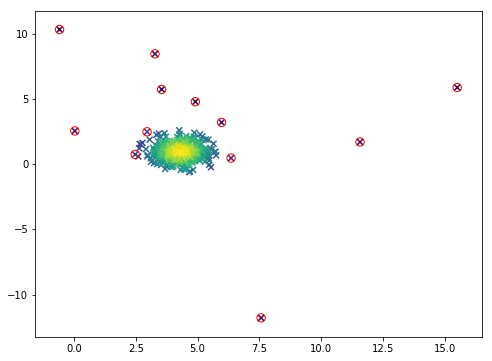

In [176]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0],X[:,1],marker="x",c=p,cmap='viridis');
# Circling of anomalies
outliers = np.nonzero(p<epsilon)[0]
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);

How well did your epsilon value do? Play around with different values until you're happy with the plot above. 

We can additionally look at our model's classification performance another way. By sorting the points ascending by their probability, and classifying the first $k$ points as anomalous, we can determine the model's precision@k. Implement this in the cell below. 

* What is the lowest value of K for which we get precision of 1.0? **K = 9**
* What is the precision for K=4? **1.0**

In [177]:
from sklearn.metrics import precision_score
for i in range(11):

    mn = sorted(p)[i]

    sc = precision_score(
            y_true, p<=mn
        )
    print("k = {}: precision {} ".format(i, sc))
print (y_true.shape)
print(p.shape)

k = 0: precision 1.0 
k = 1: precision 1.0 
k = 2: precision 1.0 
k = 3: precision 1.0 
k = 4: precision 1.0 
k = 5: precision 1.0 
k = 6: precision 1.0 
k = 7: precision 1.0 
k = 8: precision 1.0 
k = 9: precision 1.0 
k = 10: precision 0.9090909090909091 
(410,)
(410,)


You may have noticed that in this example, we are training and testing on the _entire_ dataset. This is absolutely not standard practice! You should _always_ split into a training and testing set. However, the reason that we can get away with this here is because we don't actually use labels at all during training - this is an _unsupervised_ machine learning task. Unsupervised learning methods are beneficial for anomaly detection because in the real world (i.e. testing!) we might come across types of outliers that we didn't see during training. We want to use a method that can handle this, and unsupervised methods are often better suited to this type of domain.

For the next section, we'll move to Mixture of Gaussian models. Take a look at the following dataset:

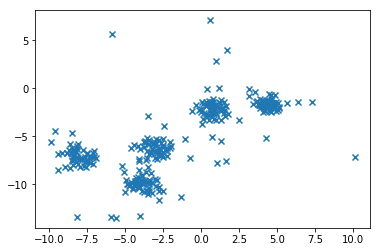

In [178]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
X, y_true = make_blobs(n_samples=400, centers=5,
                       cluster_std=0.60, random_state=1)
X_append, y_true_append = make_blobs(n_samples=50,centers=5,
                                    cluster_std=5,random_state=1)
X = np.vstack([X,X_append])
y_true = np.hstack([[0 for _ in y_true], [1 for _ in y_true_append]])
X = X[:, ::-1] # flip axes for better plotting

X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.33, random_state=1, shuffle=True)
plt.scatter(X_train[:,0],X_train[:,1],marker="x");

Okay, we have more than one cluster centre now. So what? Let's just ignore that and use the same model as before. 

* What is the precision for k=1 in the cell below? **1.0**
* k=10? **0.8181818181818182**
* k=100? **0.12871287128712872** 

In [179]:
print (y_test.shape)
print(p.shape)
print (y_true.size)


(149,)
(410,)
450


301
[ -552.35837925 -1608.13444737]
k = 1: precision 1.0 
k = 10: precision 0.8181818181818182 
k = 100: precision 0.12871287128712872 


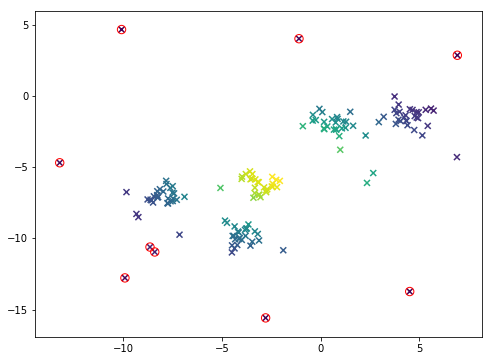

In [180]:

mu, sigma = estimateGaussian(X_train)
p = multivariateGaussian(X_test, mu, sigma)
plt.figure(figsize=(8,6))
plt.scatter(X_test[:,0],X_test[:,1],marker="x",c=p,cmap='viridis');
outliers = np.nonzero(p<0.001)[0]
plt.scatter(X_test[outliers,0],X_test[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);

k_list = [1,10,100];
from sklearn.metrics import precision_score


# sc =  precision_score(y_true,  )
for i in k_list:

    mn = sorted(p)[i]

    sc = precision_score(
            y_test, p<=mn
        )
    print("k = {}: precision {} ".format(i, sc))




Uh oh. This model performs terribly. It's fit the mean to a section of space where we don't have _any_ points, and it has absolutely no idea which points are outliers! This was probably pretty obvious to you though. We need to move to a Mixture of Gaussians model - one in which we use multiple Gaussians to fit the data. We'll use `sklearn.mixture.GaussianMixture` to do this - or rather you will! Use the documentation, found [here](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture) to initialise and fit a `GaussianMixture` object called `gm` in the cell below.

In [181]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components = 5,
                    covariance_type = 'full', random_state=0, )
gm.fit(X_train)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

Now we can use the method `gm.predict_proba()` to get the probability of each data point being in any of the five clusters:

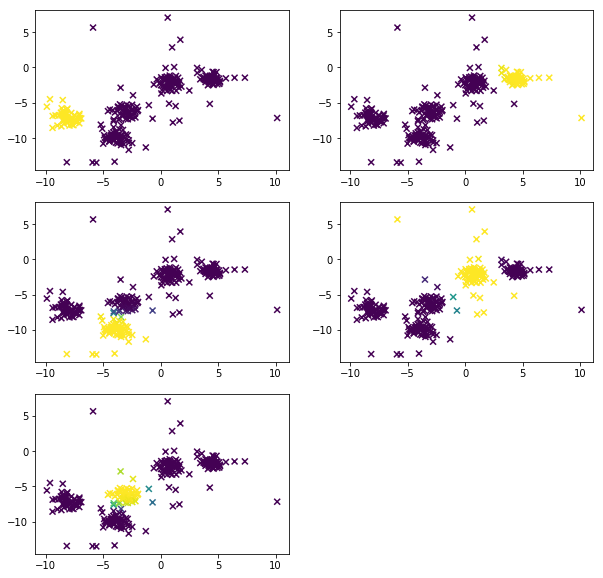

In [182]:
#plt.subplots(3,2,figsize=(8,6))
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(3,2,i+1)
    plt.scatter(X_train[:,0],X_train[:,1],c=gm.predict_proba(X_train)[:,i],cmap='viridis',marker='x')

Our Mixture of Gaussians model is powerful! Not only is it unsupervised, it can both classify points into one of the K clusters we have, _and_ it can help us with our ultimate goal of identifying outlier points! We can do this by finding the points that no cluster wants to claim for itself.

Use the following formula to calculate the probability of each point, and set it to `p`:

$$p(x) = 1 - \bigg( \prod_{i=1}^{k} 1 - p(x \in k) \bigg)$$

This formula returns the probability that the datapoint was produced at random by _any_ of the Gaussians we fit. Hence, we want to filter out anything without a very high probability of this.

In the cell below, calculate these values and then compute precision@k for k=1, 10, and 100.

* Is this model better or worse performing than the previous? **The Model performs better than the previous model**
* Why might that be? **Instead of using a single Gaussian Model, we used a mixture that fits the data better(We try to fit the data with multiple gaussians)**

For a k of  1  the precision is  1.000  and the recall is  0.056
For a k of  10  the precision is  1.000  and the recall is  0.556
For a k of  100  the precision is  0.180  and the recall is  1.000


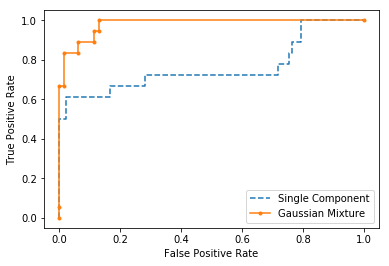

In [183]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#This part outputs the precision and recall on the test set

p_gm = gm.score_samples(X_test) #score_samples will compute the weighted log probabilities for each sample

for i in [1, 10, 100]: #Let's look at 3 different k values
   mn_gm = sorted(p_gm)[i] #We sort the points by probability, as before
   precision = precision_score(y_test, p_gm < mn_gm) #Here, we compare y_test labels to our picks using precision
   recall = recall_score(y_test, p_gm < mn_gm) #Here, we compare y_test labels to our picks using recall
   print('For a k of ',i,' the precision is ', '%.3f' % precision,' and the recall is ', '%.3f' % recall) #We print precision and recall three times

#This part computes the ROC curves for both models like we talked about in class

from sklearn.metrics import roc_curve
from matplotlib import pyplot
fpr_sc, tpr_sc, _ = roc_curve(y_test, 1-p)
fpr_gm, tpr_gm, _ = roc_curve(y_test, 1-p_gm)
pyplot.plot(fpr_sc, tpr_sc, linestyle = '--', label='Single Component')
pyplot.plot(fpr_gm, tpr_gm, marker='.', label='Gaussian Mixture')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

In [184]:
# print(X_test)
ps = gm.predict_proba(X_test)
# print(ps)
prob_list = 1-(np.prod(1-ps, axis = 1))
# print(prob_list)



for i in [1,10,100]:

    mn = sorted(prob_list)[i]

    sc = precision_score(
            y_test, prob_list<=mn
        )
    print("k = {}: precision {} ".format(i, sc))
  


k = 1: precision 0.5 
k = 10: precision 0.36363636363636365 
k = 100: precision 0.06930693069306931 


Although our MoG model doesn't perfectly identify all the outliers, it performs way better than our previous model, again without any label information to help it along!

Let's look at a dataset that motivates using a Mixture of Gaussians model: Simpsons ratings.

Everyone knows that there's a certain point when The Simpsons "got bad", but can we use a Mixture of Gaussians to find out exactly when that was?

Load up the `simpsons.pickle` file using the cell below. It contains the IMDb rating for every simpsons episode.

In [185]:
!wget https://github.com/alexwolson/APS1070_data/raw/master/simpsons.pickle
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
with open('simpsons.pickle','rb') as f:
    simpsons = pickle.load(f)
print(simpsons.values())

--2019-10-23 02:07:02--  https://github.com/alexwolson/APS1070_data/raw/master/simpsons.pickle
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alexwolson/APS1070_data/master/simpsons.pickle [following]
--2019-10-23 02:07:02--  https://raw.githubusercontent.com/alexwolson/APS1070_data/master/simpsons.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26076 (25K) [application/octet-stream]
Saving to: ‘simpsons.pickle.2’

simpsons.pickle.2   100%[===================>]  25.46K  --.-KB/s    in 0.003s  

2019-10-23 02:07:02 (7.86 MB/s) - ‘simpsons.pickle.2’ saved [26076/26076]

dict_values([{"Bart's No

With `plt.hist`, plot a histogram of the rating distribution for all Simpsons episodes. 

* What is the modal rating? **7.1**
* What is the range of ratings? **5.300000000000001**

{30: {"Bart's Not Dead": 6.2, 'Heartbreak Hotel': 6.0, 'My Way or the Highway to Heaven': 6.1, 'Treehouse of Horror XXIX': 5.9, "Baby You Can't Drive My Car": 7.0, 'From Russia Without Love': 6.6, 'Werking Mom': 5.8, 'Krusty the Clown': 6.6, 'Daddicus Finch': 6.8, "'Tis the 30th Season": 6.7, 'Mad About the Toy': 5.7, 'The Girl on the Bus': 6.3, "I'm Dancing as Fat as I Can": 6.9, 'The Clown Stays in the Picture': 6.2, '101 Mitigations': 6.4, "I Want You (She's So Heavy)": 5.8, 'E My Sports': 6.3, 'Bart vs. Itchy & Scratchy': 4.9, "Girl's in the Band": 6.2, "I'm Just a Girl Who Can't Say D'oh": 5.2, "D'oh Canada": 5.3, 'Woo-Hoo Dunnit?': 6.0, 'Crystal Blue-Haired Persuasion': 5.9}, 1: {'Simpsons Roasting on an Open Fire': 8.2, 'Bart the Genius': 7.8, "Homer's Odyssey": 7.4, "There's No Disgrace Like Home": 7.7, 'Bart the General': 8.1, 'Moaning Lisa': 7.6, 'The Call of the Simpsons': 7.8, 'The Telltale Head': 7.7, 'Life on the Fast Lane': 7.5, "Homer's Night Out": 7.4, 'The Crepes of W

(array([ 1.,  0.,  0.,  0.,  0., 10.,  1.,  2.,  1.,  6., 13., 19., 18.,
        43., 61., 70., 76., 43., 49., 27., 37., 19., 31., 51., 33., 11.,
        21., 12., 12.,  2.]),
 array([4.        , 4.17666667, 4.35333333, 4.53      , 4.70666667,
        4.88333333, 5.06      , 5.23666667, 5.41333333, 5.59      ,
        5.76666667, 5.94333333, 6.12      , 6.29666667, 6.47333333,
        6.65      , 6.82666667, 7.00333333, 7.18      , 7.35666667,
        7.53333333, 7.71      , 7.88666667, 8.06333333, 8.24      ,
        8.41666667, 8.59333333, 8.77      , 8.94666667, 9.12333333,
        9.3       ]),
 <a list of 30 Patch objects>)

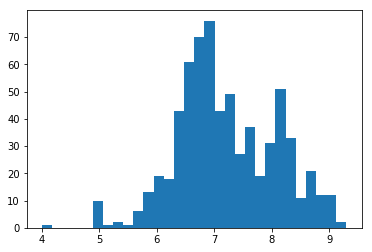

In [186]:
print(simpsons)
print(simpsons.values())

s_keys, s_values = simpsons.keys(), simpsons.values()

value_list = list(s_values)
print(value_list)
rating_list=[]

for dicts in value_list: 
    for value in dicts: 
        dicts[value] = float(dicts[value])
        rating_list.append(dicts[value])

print(rating_list)


plt.hist(rating_list, 30)

In [187]:
# ******** Calculating Range *********

print("Range : {}".format(max(rating_list) - min(rating_list)))


# ******** Calculating Modal rating ********

import collections

# calculate the frequency of each item
data = collections.Counter(rating_list)
data_list = dict(data)

# Print the items with frequency
print(data_list)

# Find the highest frequency
max_value = max(list(data.values()))
mode_val = [num for num, freq in data_list.items() if freq == max_value]
if len(mode_val) == len(rating_list):
   print("No mode in the list")
else:
   print("The Modal rating is : " + ', '.join(map(str, mode_val)))


Range : 5.300000000000001
{6.2: 18, 6.0: 4, 6.1: 15, 5.9: 11, 7.0: 40, 6.6: 37, 5.8: 2, 6.8: 33, 6.7: 37, 5.7: 4, 6.3: 26, 6.9: 36, 6.4: 17, 4.9: 1, 5.2: 1, 5.3: 1, 8.2: 27, 7.8: 19, 7.4: 11, 7.7: 24, 8.1: 24, 7.6: 13, 7.5: 16, 8.4: 14, 8.3: 19, 8.0: 13, 8.8: 9, 8.5: 11, 7.9: 18, 8.6: 14, 8.7: 7, 9.0: 6, 9.1: 6, 7.1: 43, 8.9: 3, 9.2: 1, 9.3: 1, 7.3: 22, 5.0: 9, 7.2: 27, 6.5: 24, 5.4: 1, 5.5: 1, 4.0: 1, 5.6: 2}
The Modal rating is : 7.1


Next, use `sklearn.mixture.GaussianMixture` to fit a Mixture of Gaussians to the Simpsons rating distribution. Since we are trying to distinguish between good and bad ratings, we only need 2 gaussians.

* What are the means for the two Gaussians fit by the model? **6.7734211, 8.17942889**
* What about the standard deviations? **0.59689303, 0.4741226**

In [188]:
from sklearn.mixture import GaussianMixture
gm_simp = GaussianMixture(n_components = 2,
                    covariance_type = 'full', random_state=0)


x_arr = np.array(rating_list).reshape(-1,1)
gm_simp.fit(x_arr)
print("Mean for the two fits: {}".format(gm_simp.means_))


co_var = np.array(gm_simp.covariances_)
print("Stanard Deviation for the two fits : {}".format(np.sqrt(co_var)))



Mean for the two fits: [[6.7734211 ]
 [8.17942889]]
Stanard Deviation for the two fits : [[[0.59689303]]

 [[0.4741226 ]]]


Finally, using the `GaussianMixture.predict()` method, we can use maximum likelihood to estimate which distribution, good or bad, each episode belongs to. In the cell below, count the number of episodes predicted to be in the "good" distribution per season, and plot using `plt.plot`.

* Where is the notable drop-off point? **Season 9 to Season 10**
* When is the first season with 0 good episodes? **Season 15**

{1: {'Simpsons Roasting on an Open Fire': 8.2, 'Bart the Genius': 7.8, "Homer's Odyssey": 7.4, "There's No Disgrace Like Home": 7.7, 'Bart the General': 8.1, 'Moaning Lisa': 7.6, 'The Call of the Simpsons': 7.8, 'The Telltale Head': 7.7, 'Life on the Fast Lane': 7.5, "Homer's Night Out": 7.4, 'The Crepes of Wrath': 7.8, 'Krusty Gets Busted': 8.4, 'Some Enchanted Evening': 7.8}, 2: {'Bart Gets an F': 8.2, 'Simpson and Delilah': 8.3, 'Treehouse of Horror': 8.3, 'Two Cars in Every Garage and Three Eyes on Every Fish': 8.1, "Dancin' Homer": 7.5, 'Dead Putting Society': 8.0, 'Bart vs. Thanksgiving': 7.8, 'Bart the Daredevil': 8.4, 'Itchy and Scratchy and Marge': 8.1, 'Bart Gets Hit by a Car': 7.8, 'One Fish, Two Fish, Blowfish, Blue Fish': 8.8, 'The Way We Was': 8.3, 'Homer vs. Lisa and the 8th Commandment': 8.0, 'Principal Charming': 7.5, 'Oh Brother, Where Art Thou?': 8.3, "Bart's Dog Gets an F": 7.5, 'Old Money': 7.6, 'Brush with Greatness': 8.0, "Lisa's Substitute": 8.5, 'The War of the

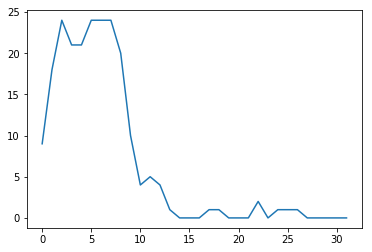

In [189]:
nested_list = []

good_list = []
simpsons = dict(sorted(list(simpsons.items()), key=lambda x: x[0]))
print(simpsons)

for i in simpsons.values():
  nested_list.append(i.values())
print(nested_list)

for i in nested_list:
  j=list(i)
  
  temp = np.array(j).reshape(-1,1)
  pred_ = np.sum(gm_simp.predict(temp))
#   print('pred',pred_)
  good_list.append(pred_)
  
print(good_list)


pyplot.plot(good_list)










## Exercises

Now we are going to work with a credit card fraud dataset (more detail can be found [here](https://www.kaggle.com/mlg-ulb/creditcardfraud/downloads/creditcardfraud.zip/3)). This dataset contains 28 key features, which are not 
directly interpretable but contain meaningful information about the dataset.

Load up the dataset using Pandas' `read_csv` function. The dataset is called `creditcard.csv`. Print out the first few columns of the dataset.

* How many rows are there?[1] **284807**
* What features in the dataset are present aside from the 28 main features?[1] **Time and Amount**
* Why do you think the main features are given to us in this way?[1] **Features V1, V2...V28 are obtained with PCA (Principal Component Analysis)**
* Which column contains the targets? Can you figure out what the values correspond to?[1] **The column "Class" contains the targets. The positive class (frauds are 1) and the negative class (non-frauds are 0)**

In [190]:
pip install wget

In [191]:

import wget
wget.download('https://github.com/alexwolson/APS1070_data/raw/master/creditcard.tar.gz','creditcard.tar.gz')

'creditcard.tar (2).gz'

In [192]:
!tar -zxvf creditcard.tar.gz

creditcard.csv


(284807, 31)
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')
0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26        0
27        0
28        0
29        0
         ..
284777    0
284778    0
284779    0
284780    0
284781    0
284782    0
284783    0
284784    0
284785    0
284786    0
284787    0
284788    0
284789    0
284790    0
284791    0
284792    0
284793    0
284794    0
284795    0
284796    0
284797    0
284798    0
284799    0
284800    0
284801    0
284802    0
284803    0
284804    0
284805    0
28

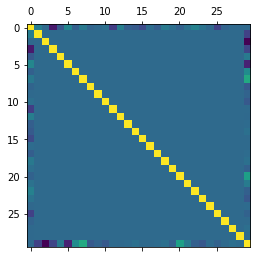

In [193]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('creditcard.csv')

# ******** Trying to Understand the Dataset******** 
print(df.shape)
print(df.columns)
print(df.Class)

# ******** Creating Features and Yhat frame *********

df_x = df.drop(columns = 'Class')
df_x.columns
df_y = df['Class']

# print(df_x, df_y)
# print(df.count())
# print(df_x.corr())

# ********* Printing a correlation plot to see the dependency of features ********
pyplot.matshow(df_x.corr())

print("The precentage of entries in Dataset for each Class are: {}".format((df['Class'].value_counts()/len(df['Class'])) * 100))

# print(df['Time'])


It's always important when looking at a new dataset to figure out how many rows we have for each class.

* What is the percentage of entries in the dataset for each class?[1] **Class 0 (Non Frauds): 99.827251% and Class 1 (Frauds): 0.172749%. The Dataset is highly unbalanced.** 
* Why might this pose a problem with methods we have looked at so far?[1] **The traditional accuracy method, is always going to be high even when the model doesn't perfrom well. Becuase in other methods, the model doesn't consider the distribution of features.**

**Ex: Let's say we want our model to label Terrorist as anamolies. And the dataset we have contains more non-terrorist (Class 0) and less terrorist (Class 1).**

**Now let's say we label every people at the airport not a terrorist, in this case the model's accuracy is going to be high (since, only few terrorist are going to be labelled as non terrorist incorrectly while the majority of people are labelled as non terrorist correctly). Thus, even when the accuracy is high, the model perform poor in identifying the anamoly. Hence, we need a different metric for unbalanced datasets.**



Next, split the dataset into a training and testing set using sklearn's `train_test_split` function. Use a test size of one third, and set the random state to 0.

Make sure to separate out the column corresponding to the targets.

As mentioned earlier, in these exercises we are going to use Gaussian distributions to model the data. To accomplish this, we are going to introduce `scipy`, a package which contains a wide variety of tools for working with scientific data in Python. Its `stats` package allows us to easily model various statistical distributions, and get information about them.

Scipy's Gaussian distribution class is called `norm`. It takes two parameters - `loc`, which corresponds to the mean of your distribution, and `scale`, which corresponds to the standard deviation.

* What are the mean and standard deviation for variable V24? Make sure to only use your training set for this.[1] **Mean : 0.0005928002728003328, Standard Deviation: 0.6071834176904295**

Use the code below to set up a Gaussian object for V24.

In [194]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.33, random_state=1, shuffle=True)
std_dev = X_train['V24'].std() 
mean = X_train['V24'].mean()
X_train.columns
print(mean, std_dev)

0.0005928002728003328 0.6071834176904295


In [0]:
from scipy import stats

norm = stats.norm( mean, std_dev
    
)

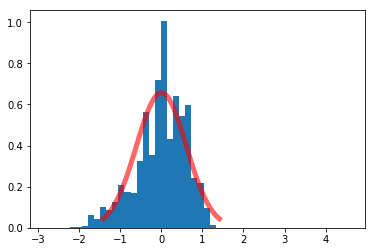

In [196]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(1, 1)
x = np.linspace(norm.ppf(0.01),
                norm.ppf(0.99), 100)
ax.plot(x, norm.pdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')
ax.hist(X_train['V24'].values, density=True, histtype='stepfilled', bins=50);
plt.show()

We can also look at the difference in distribution for some variables between fraudulent and non-fraudulent transactions:

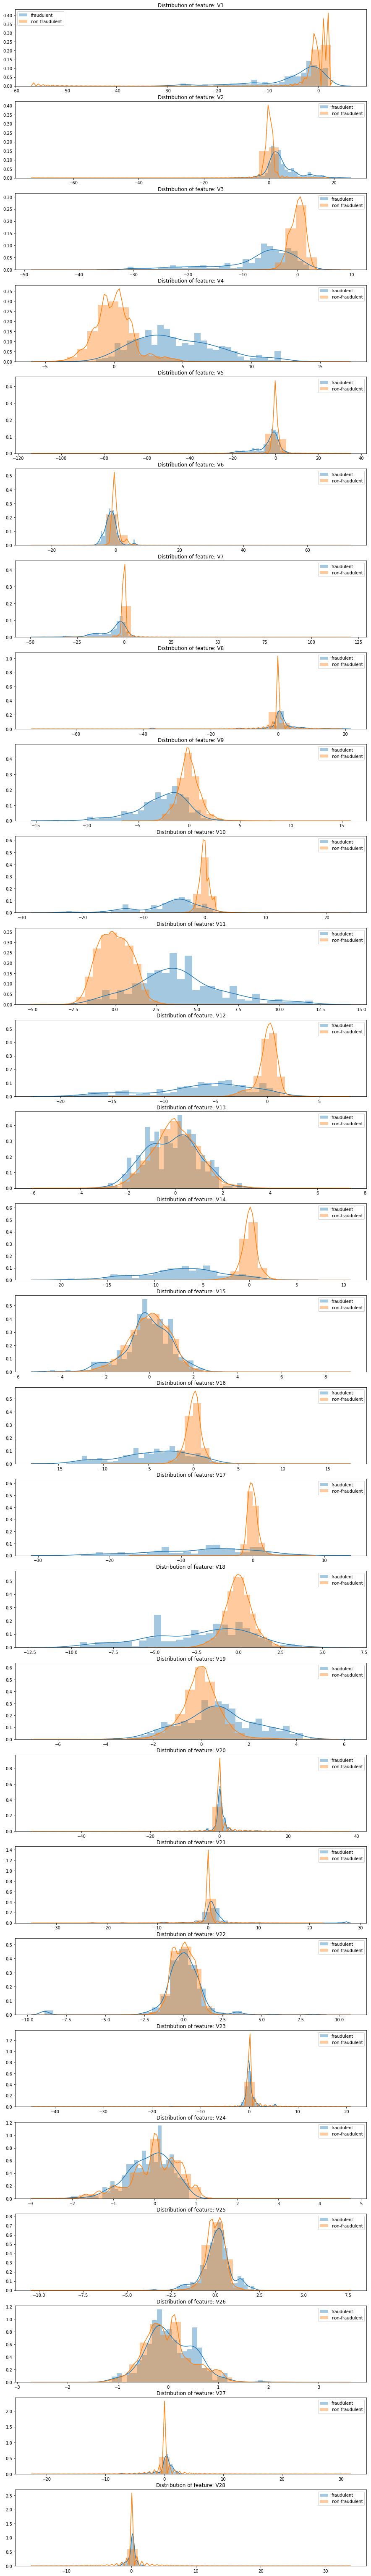

In [197]:
import matplotlib.gridspec as gridspec
import seaborn as sns
features=[f for f in df.columns if 'V' in f]
nplots=np.size(features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, feat in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.distplot(X_train[feat][y_train==1], bins=30)
    sns.distplot(X_train[feat][y_train==0],bins=30)
    ax.legend(['fraudulent', 'non-fraudulent'],loc='best')
    ax.set_xlabel('')
    ax.set_title('Distribution of feature: ' + feat)

Build an outlier detection model using a Mixture of Gaussians using a subset of features of your choice (pick a few) and a number of mixture components. Report the precision@k for k=1, 10 and 100 (on test data). Repeat this model creation process at least 4 more times, each time selecting different parameters (features selected, number of mixture components), and reporting the precision as above. Organize your findings in a table or plot and describe your findings. What can you conclude about what models work best? [3]

**We plotted the distribution plot of each feature since the confusion matrix in this case did not provide any useful correlation between the features. I am picking up the features in which the Fraudlent (Class 1) and Non Fraudlent (Class 0) classes overlap less in the distribution. Here are the analysis and Precision - Recursion graph of five such cases.** 

**CASE 1 : NUMBER OF MIXTURE COMPONENTS = 1, FEATURE = V17**

In [0]:
from sklearn.metrics import f1_score
from sklearn.mixture import GaussianMixture

gm_cred = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0 )

df_case_1_x_train = X_train.loc[:, ['V17']]
df_case_1_x_test = X_test.loc[:, ['V17']]

gm_cred.fit(df_case_1_x_train)
y_pred = gm_cred.predict(df_case_1_x_test)


# print(df_case_1_x.shape)
# print(X_train.shape)
# print(y_train.shape)
# print(y_test)



For a k of  1  the precision is  1.000  and the recall is  0.007
For a k of  10  the precision is  1.000  and the recall is  0.068
For a k of  100  the precision is  0.620  and the recall is  0.419
f1 Score for case 1 is 0.5


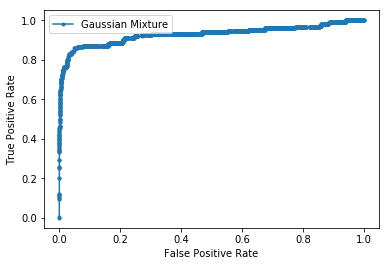

In [199]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


p_gm_1 = gm_cred.score_samples(df_case_1_x_test)


for i in [1, 10, 100]: 
   mn_gm_1 = sorted(p_gm_1)[i] 
   precision_1 = precision_score(y_test, p_gm_1 < mn_gm_1)
   recall_1 = recall_score(y_test, p_gm_1 < mn_gm_1)
   print('For a k of ',i,' the precision is ', '%.3f' % precision_1,' and the recall is ', '%.3f' % recall_1) 
  

  
#F1 Score
  
F1_1 = 2 * (precision_1 * recall_1) / (precision_1 + recall_1)
print("f1 Score for case 1 is {}".format(F1_1))
  
  
  
#ROC curve

from sklearn.metrics import roc_curve
from matplotlib import pyplot


fpr_gm_1, tpr_gm_1, _ = roc_curve(y_test, 1-p_gm_1)

pyplot.plot(fpr_gm_1, tpr_gm_1, marker='.', label='Gaussian Mixture')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()



**CASE 2 : FEATURES = V3, V4 ;  NO. OF COMPONENTS = 2**

In [0]:
from sklearn.metrics import f1_score
from sklearn.mixture import GaussianMixture

gm_cred_2 = GaussianMixture(n_components = 2,
                    covariance_type = 'full', random_state=0 )



df_case_2_x_train = X_train.loc[:, ['V3', 'V4']]
df_case_2_x_test = X_test.loc[:, ['V3', 'V4']]

gm_cred_2.fit(df_case_2_x_train)
y_pred_2 = gm_cred_2.predict(df_case_2_x_test)

For a k of  1  the precision is  0.000  and the recall is  0.000
For a k of  10  the precision is  0.600  and the recall is  0.041
For a k of  100  the precision is  0.300  and the recall is  0.203
f1 Score for case 2 is 0.24193548387096778


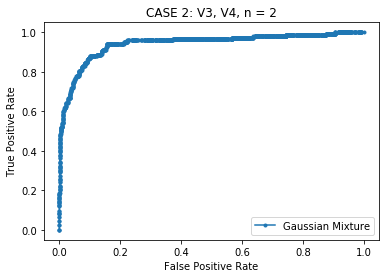

In [201]:
p_gm_2 = gm_cred_2.score_samples(df_case_2_x_test)


for i in [1, 10, 100]: 
   mn_gm_2 = sorted(p_gm_2)[i] 
   precision_2 = precision_score(y_test, p_gm_2 < mn_gm_2)
   recall_2 = recall_score(y_test, p_gm_2 < mn_gm_2)
   print('For a k of ',i,' the precision is ', '%.3f' % precision_2,' and the recall is ', '%.3f' % recall_2) 
  
#F1 Score
  
F1_2 = 2 * (precision_2 * recall_2) / (precision_2 + recall_2)
print("f1 Score for case 2 is {}".format(F1_2))
  

  
  
#ROC curve

from sklearn.metrics import roc_curve
from matplotlib import pyplot

fpr_gm_2, tpr_gm_2, _ = roc_curve(y_test, 1-p_gm_2)

pyplot.plot(fpr_gm_2, tpr_gm_2, marker='.', label='Gaussian Mixture')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title ('CASE 2: V3, V4, n = 2')
pyplot.legend()

**CASE 3: FEATURES = V14, V16 NO. OF COMPONENTS =  1**

In [0]:
from sklearn.metrics import f1_score
from sklearn.mixture import GaussianMixture

gm_cred_3 = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0 )


df_case_3_x_train = X_train.loc[:, ['V14', 'V16']]
df_case_3_x_test = X_test.loc[:, ['V14', 'V16']]

gm_cred_3.fit(df_case_3_x_train)
y_pred_3 = gm_cred_3.predict(df_case_3_x_test)

For a k of  1  the precision is  1.000  and the recall is  0.007
For a k of  10  the precision is  0.900  and the recall is  0.061
For a k of  100  the precision is  0.750  and the recall is  0.507
f1 Score for case 3 is 0.6048387096774194


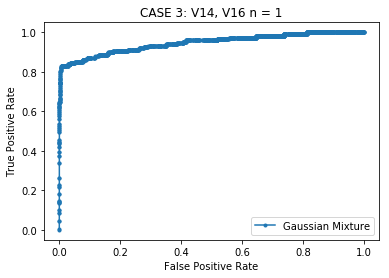

In [203]:
p_gm_3 = gm_cred_3.score_samples(df_case_3_x_test)


for i in [1, 10, 100]: 
   mn_gm_3 = sorted(p_gm_3)[i] 
   precision_3 = precision_score(y_test, p_gm_3 < mn_gm_3)
   recall_3 = recall_score(y_test, p_gm_3 < mn_gm_3)
   print('For a k of ',i,' the precision is ', '%.3f' % precision_3,' and the recall is ', '%.3f' % recall_3) 
  
#F1 Score
  
F1_3 = 2 * (precision_3 * recall_3) / (precision_3 + recall_3)
print("f1 Score for case 3 is {}".format(F1_3))
  
  
#ROC curve

from sklearn.metrics import roc_curve
from matplotlib import pyplot

fpr_gm_3, tpr_gm_3, _ = roc_curve(y_test, 1-p_gm_3)

pyplot.plot(fpr_gm_3, tpr_gm_3, marker='.', label='Gaussian Mixture')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title ('CASE 3: V14, V16 n = 1')
pyplot.legend()

**CASE 4: FEATURE = V26, V27, V28 ; NO. OF FEATURES = 1**


In [0]:
from sklearn.metrics import f1_score
from sklearn.mixture import GaussianMixture

gm_cred_4 = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0 )


df_case_4_x_train = X_train.loc[:, ['V26', 'V27', 'V28']]
df_case_4_x_test = X_test.loc[:, ['V26', 'V27', 'V28']]

gm_cred_4.fit(df_case_4_x_train)
y_pred_4 = gm_cred_4.predict(df_case_4_x_test)

For a k of  1  the precision is  0.000  and the recall is  0.000
For a k of  10  the precision is  0.000  and the recall is  0.000
For a k of  100  the precision is  0.000  and the recall is  0.000
f1 Score for case 4 is nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


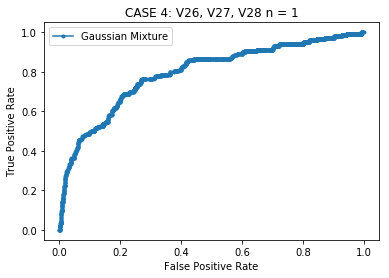

In [205]:
p_gm_4 = gm_cred_4.score_samples(df_case_4_x_test)

for i in [1, 10, 100]: 
   mn_gm_4 = sorted(p_gm_4)[i] 
   precision_4 = precision_score(y_test, p_gm_4 < mn_gm_4)
   recall_4 = recall_score(y_test, p_gm_4 < mn_gm_4)
   print('For a k of ',i,' the precision is ', '%.3f' % precision_4,' and the recall is ', '%.3f' % recall_4) 
  
#F1 Score
  
F1_4 = 2 * (precision_4 * recall_4) / (precision_4 + recall_4)
print("f1 Score for case 4 is {}".format(F1_4))
  
  
  
#ROC curve

from sklearn.metrics import roc_curve
from matplotlib import pyplot

fpr_gm_4, tpr_gm_4, _ = roc_curve(y_test, 1-p_gm_4)

pyplot.plot(fpr_gm_4, tpr_gm_4, marker='.', label='Gaussian Mixture')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title ('CASE 4: V26, V27, V28 n = 1')
pyplot.legend()

**CASE 5 : V14, V16 NO. OF COMPONENTS = 2**

In [0]:
from sklearn.metrics import f1_score
from sklearn.mixture import GaussianMixture

gm_cred_5 = GaussianMixture(n_components = 2,
                    covariance_type = 'full', random_state=0 )


df_case_5_x_train = X_train.loc[:, ['V14', 'V16']]
df_case_5_x_test = X_test.loc[:, ['V14', 'V16']]

gm_cred_5.fit(df_case_5_x_train)
y_pred_5 = gm_cred_5.predict(df_case_5_x_test)

For a k of  1  the precision is  1.000  and the recall is  0.007
For a k of  10  the precision is  0.900  and the recall is  0.061
For a k of  100  the precision is  0.680  and the recall is  0.459
f1 Score for case 4 is 0.5483870967741935


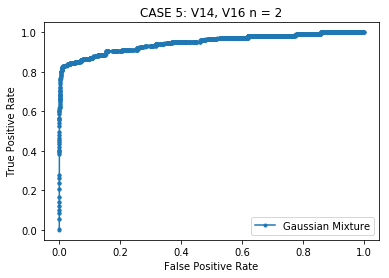

In [207]:
p_gm_5 = gm_cred_5.score_samples(df_case_5_x_test)

for i in [1, 10, 100]: 
   mn_gm_5 = sorted(p_gm_5)[i] 
   precision_5 = precision_score(y_test, p_gm_5 < mn_gm_5)
   recall_5 = recall_score(y_test, p_gm_5 < mn_gm_5)
   print('For a k of ',i,' the precision is ', '%.3f' % precision_5,' and the recall is ', '%.3f' % recall_5) 
  
#F1 Score
  
F1_5 = 2 * (precision_5 * recall_5) / (precision_5+ recall_5)
print("f1 Score for case 4 is {}".format(F1_5))
  
  
  
#ROC curve

from sklearn.metrics import roc_curve
from matplotlib import pyplot

fpr_gm_5, tpr_gm_5, _ = roc_curve(y_test, 1-p_gm_5)

pyplot.plot(fpr_gm_5, tpr_gm_5, marker='.', label='Gaussian Mixture')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title ('CASE 5: V14, V16 n = 2')
pyplot.legend()

In [208]:
print(F1_1, F1_2, F1_3, F1_4, F1_5)

0.5 0.24193548387096778 0.6048387096774194 nan 0.5483870967741935


**The Precision and Recall scores of each case, can be used to calculate f1 Score. It helps in comparing different models. Here, I've calculated a balanced f1 score(beta = 0.5) Case 3 has the highest f1 score indicating that the model performed well in identifying the outliers compared to the other models.**

**(Case 4 f1_score is nan, since it's 0/0)**

**Graphically, it can also be inferred from the distribution plots of features. The features in which the overlapping of fraudlent and non fraudlent classes is less, perfoms better.**

**For better comparison of the cases (as TA suggested!) I am plotting the "Precision - k" and "Recall - k" curves to show that the Case 3 Model performs well than the other models.**

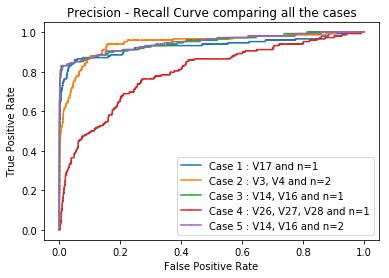

In [209]:
pyplot.plot(fpr_gm_1, tpr_gm_1, marker=',', label='Case 1 : V17 and n=1')
pyplot.plot(fpr_gm_2, tpr_gm_2, marker=',', label='Case 2 : V3, V4 and n=2')
pyplot.plot(fpr_gm_3, tpr_gm_3, marker=',', label='Case 3 : V14, V16 and n=1')
pyplot.plot(fpr_gm_4, tpr_gm_4, marker=',', label='Case 4 : V26, V27, V28 and n=1')
pyplot.plot(fpr_gm_5, tpr_gm_5, marker=',', label='Case 5 : V14, V16 and n=2')

pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title ('Precision - Recall Curve comparing all the cases')
pyplot.legend()

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


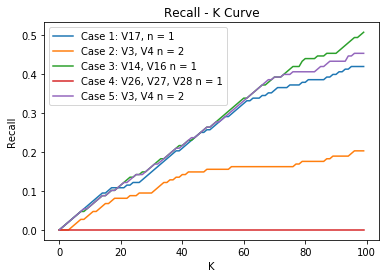

In [210]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score



precision_1_list = []
recall_1_list = []
precision_2_list = []
recall_2_list = []
precision_3_list = []
recall_3_list = []
precision_4_list = []
recall_4_list = []
precision_5_list = []
recall_5_list = []



for i in range(100): 
   mn_gm_1 = sorted(p_gm_1)[i] 
   pr1 = precision_score(y_test, p_gm_1 < mn_gm_1)
   precision_1_list.append(pr1)
   rc1 = recall_score(y_test, p_gm_1 < mn_gm_1)  
   recall_1_list.append(rc1)
    
for i in range(100):    
   mn_gm_2 = sorted(p_gm_2)[i] 
   pr2 = precision_score(y_test, p_gm_2 < mn_gm_2)
   precision_2_list.append(pr2)
   rc2 = recall_score(y_test, p_gm_2 < mn_gm_2)  
   recall_2_list.append(rc2)
    
for i in range(100):  
   mn_gm_3 = sorted(p_gm_3)[i] 
   pr3 = precision_score(y_test, p_gm_3 < mn_gm_3)
   precision_3_list.append(pr3)
   rc3 = recall_score(y_test, p_gm_3 < mn_gm_3)  
   recall_3_list.append(rc3)
    
for i in range(100):    
   mn_gm_4 = sorted(p_gm_4)[i] 
   pr4 = precision_score(y_test, p_gm_4 < mn_gm_4)
   precision_4_list.append(pr4)
   rc4 = recall_score(y_test, p_gm_4 < mn_gm_4)  
   recall_4_list.append(rc4)
    
for i in range(100):    
   mn_gm_5 = sorted(p_gm_5)[i] 
   pr5 = precision_score(y_test, p_gm_5 < mn_gm_5)
   precision_5_list.append(pr5)
   rc5 = recall_score(y_test, p_gm_5 < mn_gm_5)  
   recall_5_list.append(rc5)
 
pyplot.plot(recall_1_list, label = 'Case 1: V17, n = 1')
pyplot.plot(recall_2_list, label = 'Case 2: V3, V4 n = 2')
pyplot.plot(recall_3_list, label = 'Case 3: V14, V16 n = 1')
pyplot.plot(recall_4_list, label = 'Case 4: V26, V27, V28 n = 1')
pyplot.plot(recall_5_list, label = 'Case 5: V3, V4 n = 2')


pyplot.xlabel('K')
pyplot.ylabel('Recall')
pyplot.title ('Recall - K Curve')
pyplot.legend()

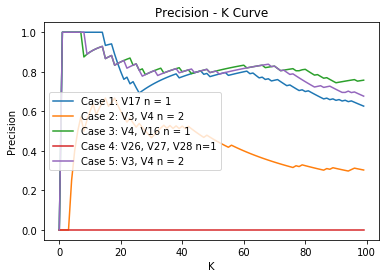

In [211]:
pyplot.plot(precision_1_list, label = 'Case 1: V17 n = 1')
pyplot.plot(precision_2_list, label = 'Case 2: V3, V4 n = 2')
pyplot.plot(precision_3_list, label = 'Case 3: V4, V16 n = 1')
pyplot.plot(precision_4_list, label = 'Case 4: V26, V27, V28 n=1')
pyplot.plot(precision_5_list, label = 'Case 5: V3, V4 n = 2 ')

pyplot.xlabel('K')
pyplot.ylabel('Precision')
pyplot.title ('Precision - K Curve')
pyplot.legend()

**Thus from the above plots, The precision and recall is high for Case 3 as K increases and it performs better than the other cases. The models are arranged from best to worst below. 

**1. Case 3 : V14, V16 and n = 1**

**2. Case 5 : V14, V16 and n = 2**

**3. Case 1 : V17 and n = 1**

**4. Case 2 : V3, V4 and n = 2**

**5. Case 5 : V26, V27, V28 and n = 1 (Obviously! since the classes overlapped the most in these features!)**